In [ ]:
class RandomForest():
    def __init__(self,x,y,n_trees,n_features,sample_sz,depth = 10, min_leaf = 5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
        print(self.n_features, 'sha:',x.shape[1])
        self.x,self.y,self.sample_sz,self.depth,self.min_leaf = x,y,sample_sz,depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
        
    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.n_features, f_idxs, 
                           idxs = np.array(range(self.sample_sz)), depth = self.depth,min_leaf = self.min_leaf)
    
    def predict(self,x):
        return np.mean([t.predict(x) for t in self.trees], axis = 0)
    

In [ ]:
import math
def std_agg(cnt,s1,s2):
    return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [ ]:
class DecisionTree():
    def __init__(self,x,y,n_features,f_idxs,idxs,depth = 10,min_leaf = 5):
        self.x,self.y,self.idxs,self.min_leaf,self.f_idxs = x,y,idxs,min_leaf,f_idxs
        self.depth = depth
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('int')
        self.find_varsplit()
    
    @property
    def split_col(self):
        return self.x.values[self.idxs,self.var_idx]
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 

    def find_varsplit(self):
        for i in self.f_idxs: 
            self.find_better_split(i)
        if self.is_leaf: return   
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        
        self.lhs = DecisionTree(self.x,self.y,self.n_features,lf_idxs,self.idxs[lhs],depth = self.depth -1, min_leaf = self.min_leaf)
        self.rhs = DecisionTree(self.x,self.y,self.n_features,rf_idxs,self.idxs[rhs],depth = self.depth -1, min_leaf = self.min_leaf)
        
        
        
    
    def find_better_split(self,var_idx):
        x, y = self.x.values[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n,sort_y.sum(),(sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
        
        for i in range(0, self.n - self.min_leaf -1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum += yi**2; rhs_sum2 -= yi**2
            
            if i < self.min_leaf or xi == sort_x[i+1]:
                continue
            
            lhs_std = std_agg(lhs_cnt,lhs_sum,lhs_sum2)
            rhs_std = std_agg(rhs_cnt,rhs_sum,rhs_sum2)
            
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            
            if curr_score < self.score:
                self.var_idx, self.score,self.split = var_idx, curr_score, xi
    
    def predict(self,x):
        return np.array([self.predict_row(xi) for xi in x])
    
    def predict_row(self,xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)
            

In [ ]:
import warnings
import pandas as pd
import pydataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
plt.style.use("seaborn")
warnings.filterwarnings("ignore")
labeler = LabelBinarizer()
# pima 
train = pydataset.data("Pima.tr") # 200 subjects
test = pydataset.data("Pima.te") # remaining 332 subjects
names = train.columns[:-1]
X_train = train.values[:, :-1]
y_train = labeler.fit_transform(train.values[:, -1]).flatten()
X_test = test.values[:, :-1]
y_test = labeler.transform(test.values[:, -1]).flatten()
print(train["type"].value_counts())
print(test["type"].value_counts())
train

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
cart = DecisionTreeClassifier(criterion = 'entropy', ccp_alpha = 0.1)
bagging = BaggingClassifier(cart, n_estimators = 100)
bagging.fit(X_train,y_train)


In [9]:
import numpy as np
print("Training accuracy = ", (bagging.predict(X_train) == y_train).mean())
print("Testing accuracy =  ", (bagging.predict(X_test) == y_test).mean())
fi = np.array([est.feature_importances_ for est in bagging.estimators_])
print(pd.DataFrame({'importance':fi.mean(0)}, index = names))

Training accuracy =  0.775
Testing accuracy =   0.7831325301204819
       importance
npreg    0.000000
glu      0.745660
bp       0.000000
skin     0.012802
bmi      0.032848
ped      0.019959
age      0.188730


In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
rf.fit(X_train,y_train)
print("Training accuracy = ", (rf.predict(X_train) == y_train).mean())
print("Testing accuracy =  ", (rf.predict(X_test) == y_test).mean())
print(pd.DataFrame({"importance": rf.feature_importances_}, index=names))

Training accuracy =  1.0
Testing accuracy =   0.7560240963855421
       importance
npreg    0.108082
glu      0.229330
bp       0.091912
skin     0.107949
bmi      0.166965
ped      0.149472
age      0.146290


# Simulated Data

In [12]:
import matplotlib as mpl
from matplotlib import colors
cmap = colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap = cmap)

def plot_boundary(fit, X,y, ax, res = 100, dim = (0,1)):
    ax.scatter(X[:,dim[0]], X[:,dim[1]], c= y,  cmap = 'red_blue_classes',
              linewidths = 1., edgecolors = 'white')
    xrange = ax.get_xlim()
    yrange = ax.get_ylim()
    xx,yy = np.meshgrid(np.linspace(*xrange,res),
                       np.linspace(*yrange,res))
    xxf = xx.flatten()
    yyf = yy.flatten()
    xm = X.mean(0)
    XX = np.vstack([xm for _ in range(xxf.shape[0])])
    XX[:,dim[0]] = xxf
    XX[:,dim[1]] = yyf
    ZZ = fit.predict_proba(XX)
    zz = ZZ[:,1].reshape(xx.shape)
    mesh = ax.pcolormesh(xx,yy,zz, cmap = 'red_blue_classes', shading = 'auto',
                        norm = colors.Normalize(0.,1.), zorder = 0)
    plt.colorbar(mesh, ax=ax)
    ax.contour(xx, yy, zz, [0.5], linewidths=2., colors='white')
    ax.set_title("Accuracy = {:.3f}".format((fit.predict(X)==y).mean()))

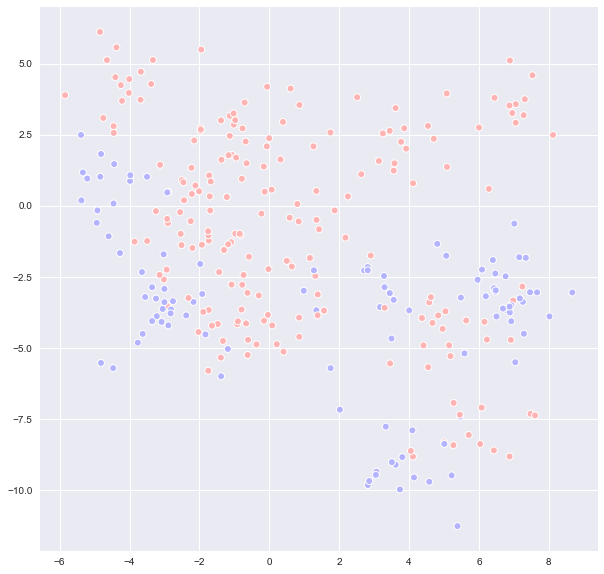

In [22]:
np.random.seed(1)
K =20
p =2
N =300
mu = np.random.normal(0.,4.,(K,2))
component = np.random.randint(0,K,(N,))
assignment = np.random.randint(0,2,(K,))
X = mu[component,:] + np.random.normal(0.,1.,(N,p))
y = assignment[component]
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.scatter(X[:, 0], X[:, 1], c=y, cmap="red_blue_classes",
              linewidths=1., edgecolors="white")

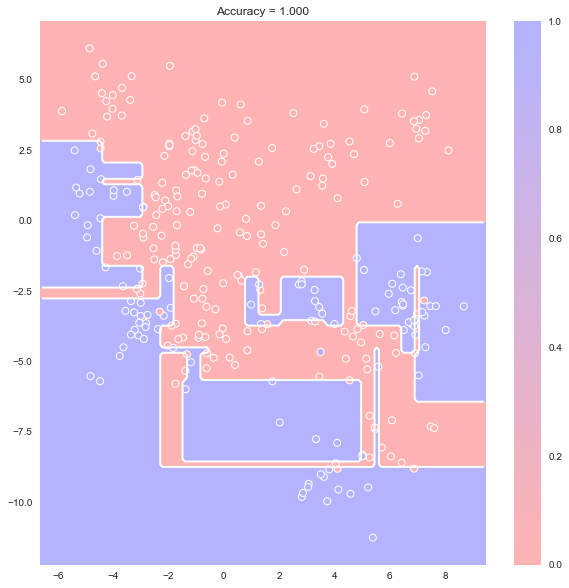

In [23]:
fit = DecisionTreeClassifier().fit(X,y)
fig,ax = plt.subplots(1,1,figsize = (10,10))
plot_boundary(fit,X,y,ax,res = 100,dim = (0,1))

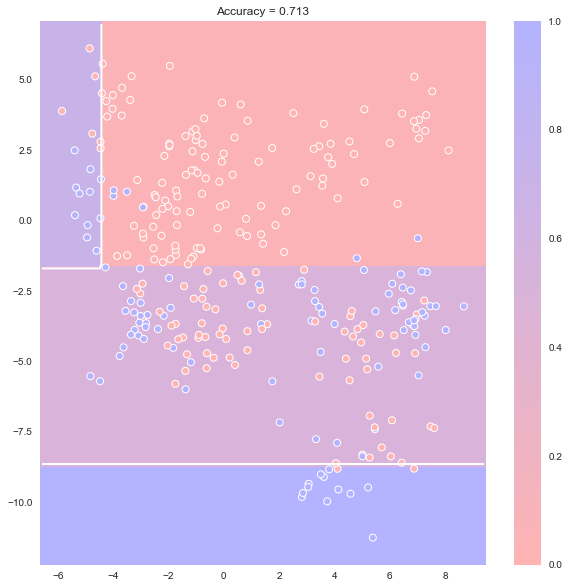

In [24]:
fit = DecisionTreeClassifier(max_depth=2).fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_boundary(fit, X, y, ax, res=100, dim=(0, 1))

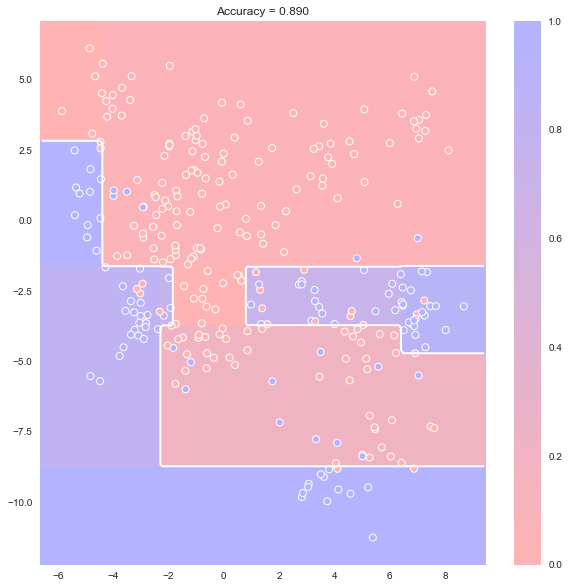

In [25]:
# decision tree, pruning
fit = DecisionTreeClassifier(ccp_alpha=0.01).fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_boundary(fit, X, y, ax, res=100, dim=(0, 1))

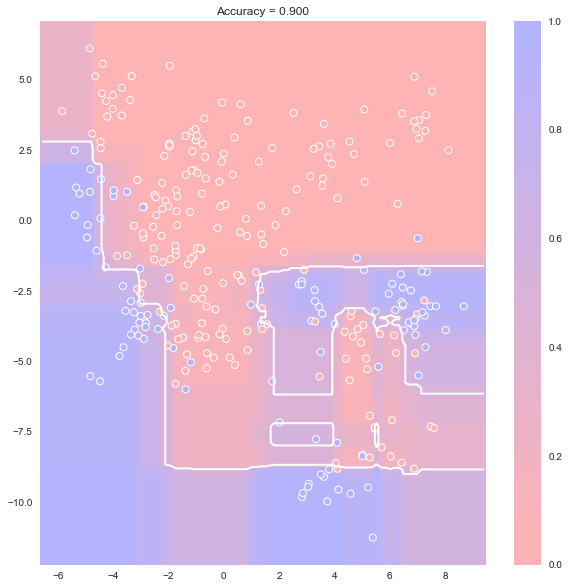

In [26]:
# bagging
fit = BaggingClassifier(DecisionTreeClassifier(ccp_alpha=0.01), n_estimators=10).fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_boundary(fit, X, y, ax, res=100, dim=(0, 1))

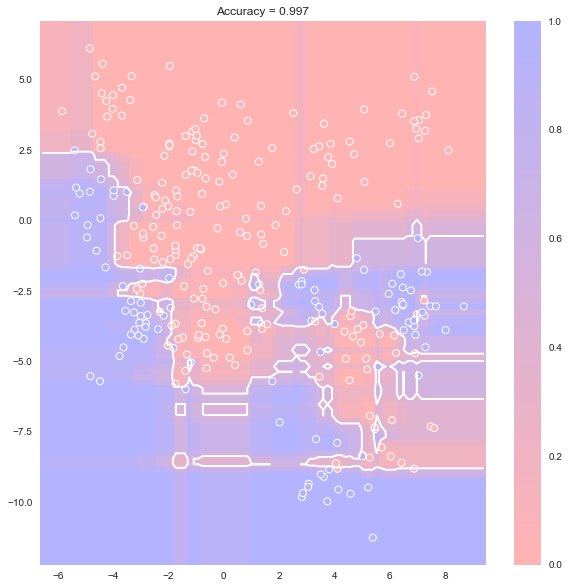

In [27]:
# RF
fit = RandomForestClassifier(n_estimators=10, criterion="entropy").fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_boundary(fit, X, y, ax, res=100, dim=(0, 1))